## linkz

http://stackoverflow.com/questions/33997823/tensorflow-mlp-not-training-xor  
https://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf  

# Biblioteke

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from matplotlib import _cntr as cntr
import tensorflow as tf

# Random2DGaussian 1. dio

In [14]:
class Random2DGaussian():
    def __init__(self, minx=0,maxx=10,miny=0,maxy=10):
        self.minx = minx
        self.maxx = maxx
        self.miny = miny
        self.maxy = maxy
        self.mean = (np.random.random_sample()*(self.maxx-self.minx)+self.minx,np.random.random_sample()*(self.maxy-self.miny)+self.miny)
        self.cov_matrix = self.create_cov_matrix()
        
    def create_cov_matrix(self):
        eigenvalx = (np.random.random_sample() * (self.maxx-self.minx)/5)**2
        eigenvaly = (np.random.random_sample() * (self.maxy-self.miny)/5)**2
        D = np.array([[eigenvalx,0],[0,eigenvaly]])
        angle = np.random.random_sample() * 2*np.pi - np.pi #angle in radians
        R = np.array([[np.cos(angle), np.sin(-angle)],[np.sin(angle),np.cos(angle)]])
        cov_matrix = np.dot(np.dot(np.transpose(R),D),R)
        return cov_matrix
        
    def get_sample(self,n):
        return np.random.multivariate_normal(self.mean, self.cov_matrix, n)
    
def sample_gauss_2d(C,N):
    if C==1:
        G = Random2DGaussian()
        X = G.get_sample(N)
        Y = np.array([0]*N)
        return X, Y
    else:
        G = Random2DGaussian()
        X = G.get_sample(N)
        Y = np.array([0]*N)
        for i in range(1,C):
            G = Random2DGaussian()
            X = np.vstack((X,G.get_sample(N)))
            Y = np.vstack((Y,[i]*N))
        return X, Y.flatten()

def sample_gmm_2d(K,C,N):
    if K==0 or C <1:
        raise Exception("Number of classes needs to be 1 or more, and number of bivariant distributions needs to be greater than zero")
    for i in range(0,K):
        G = Random2DGaussian()
        rand_class = np.random.randint(low=0,high=C)
        if i==0:
            X=G.get_sample(N)
            Y=[rand_class]*N
            continue
        X = np.vstack((X,G.get_sample(N)))
        Y = np.vstack((Y,[rand_class]*N))
        
    return X, Y.flatten()

    

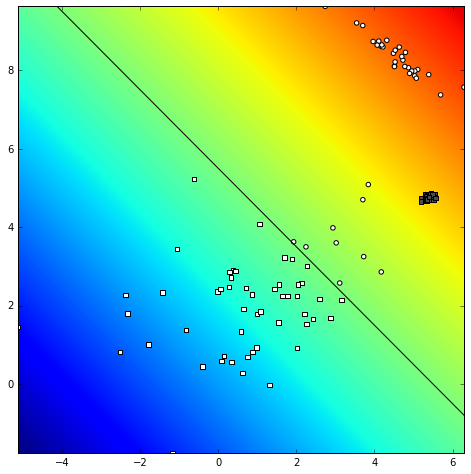

In [100]:
def myDummyDecision(X):
    scores = X[:,0] + X[:,1] - 5
    return scores

np.random.seed(250)
# get the training dataset
X,Y_ = sample_gmm_2d(4,2,30)

# get the class predictions
Y = myDummyDecision(X)>0.5

# graph the decision surface
decfun = myDummyDecision
bbox=(np.min(X, axis=0), np.max(X, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, Y)
# show the results
plt.show()

## Graficki prikaz klasifikacije

In [75]:
def graph_data(X,Y_,Y):
    correctly_classified = X[np.where(Y==Y_)]
    incorrectly_classified = X[np.where(Y!=Y_)]
    
    colors = np.array([0.3]*len(X))
    colors[np.where(Y_==1)] = 1
    
    color_correct = colors[np.where(Y==Y_)]
    color_incorrect = colors[np.where(Y!=Y_)]
    
    plt.scatter(correctly_classified[:,0],correctly_classified[:,1],color=zip(color_correct,color_correct,color_correct),marker='o',edgecolors=(0,0,0))
    plt.scatter(incorrectly_classified[:,0],incorrectly_classified[:,1],color=zip(color_incorrect,color_incorrect,color_incorrect),marker='s',edgecolors=(0,0,0))
    
def graph_surface(fun, rect, offset=0):
    xmin,ymin = bbox[0]
    xmax,ymax = bbox[1]
    x_range = np.linspace(xmin,xmax,num=1000)
    y_range = np.linspace(ymin,ymax,num=1000)
    x,y = np.meshgrid(x_range,y_range)
    grid = np.stack((x.flatten(),y.flatten())).transpose()
    dec = fun(grid)
    
    delta = np.abs(dec-offset).max()
    c = cntr.Cntr(x, y, dec.reshape(x.shape))
    res = c.trace(offset)
    nseg = len(res) // 2
    segments, codes = res[:nseg], res[nseg:]
    plt.plot(segments[0][:,0],segments[0][:,1],color=(0,0,0))
    plt.pcolormesh(x, y, dec.reshape(x.shape),vmin = offset-delta, vmax=offset+delta)
    

## fcann2

In [168]:
def fcann2_train(input_data,out_data,n_hidden,n_classes):
    
    output_data = np.zeros((len(out_data),n_classes))
    output_data[range(len(out_data)),out_data] = 1
    
    param_niter=10000
    param_delta=0.05
    param_lambda=0.5
    
    x = tf.placeholder(tf.float32,[None, 2], name="input")
    
    #layer 1
    W1 = tf.Variable(tf.random_normal([2, n_hidden]))
    b1 = tf.Variable(tf.random_normal([n_hidden]))
    y1 = tf.nn.relu(tf.matmul(x, W1) + b1)
    
    #output
    W2 = tf.Variable(tf.random_normal([n_hidden, n_classes]))
    b2 = tf.Variable(tf.random_normal([n_classes]))
    y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)
    
    y = y2
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,y_))
    #cost = tf.reduce_mean(-(y_ * tf.log(y) + (1 - y_) * tf.log(1 - y)))
    optimizer = tf.train.AdamOptimizer(learning_rate = param_delta).minimize(cost)
    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
        sess.run(init)
        for iter in range(param_niter):
            values = sess.run([optimizer],feed_dict={x:input_data,y_:output_data})
            #print values
        #print "nakon treniranja u sessionu",input_data[0],sess.run([y], feed_dict={'input:0':[input_data[0]]}), output_data[0]
        saver = tf.train.Saver()
        save_path = saver.save(sess, "model.ckpt")
    
    return y, save_path

def load_session(session, model_path):
    saver = tf.train.Saver()
    saver.restore(sess, model_path)

def fcann2_classify(X,model):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        value = sess.run([model], feed_dict={'input:0':X})
        np_values = np.array(value)
        #print "classify istreniranog",[X[0]], np.array(value)[0] , np.argmax(np.array(value)[0],axis=1), np.array(value)[0].shape
        #print np.argmax(np_values[0],axis=1), len(np_values[0]), np_values[0].shape
        #return np_values[0][range(len(np_values[0])),np.argmax(np_values[0],axis=1)]
        return np_values[0][:,1]
    
    
np.random.seed(250)
# get the training dataset
X,Y_ = sample_gmm_2d(4,2,30)

#Makni ovo, samo zato sto tensorflow radi pizdarije s imenima pa pamti u default graphu gluparije
tf.reset_default_graph()
ytrained, save_path = fcann2_train(X,Y_,5,2)
def predict(X,save_path):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        value = sess.run([ytrained], feed_dict={'input:0':X})
        np_values = np.array(value)
    return np_values[0][:,1]

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    load_session(sess,save_path)
    value = sess.run([ytrained], feed_dict={'input:0':X})
    np_values = np.array(value)
    prvi = np_values[0][:,1]
#     value = sess.run([ytrained], feed_dict={'input:0':X})
#     np_values = np.array(value)
#     drugi = np_values[0][:,1]
    
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    load_session(sess,save_path)
#     value = sess.run([ytrained], feed_dict={'input:0':X})
#     np_values = np.array(value)
#     prvi = np_values[0][:,1]
    value = sess.run([ytrained], feed_dict={'input:0':X})
    np_values = np.array(value)
    drugi = np_values[0][:,1]
# prvi = predict(X)
# drugi = predict(X)

print prvi.shape, drugi.shape, type(prvi), type(drugi)
print prvi
print drugi
print prvi-drugi
    

#     # graph the decision surface
#     decfun = binlogreg_decfun(X,ytrained)
#     bbox=(np.min(X, axis=0), np.max(X, axis=0))
#     #axis limits of the graph
#     xmin, ymin = bbox[0]
#     xmax, ymax = bbox[1]
#     plt.figure(figsize=(8,8))
#     plt.xlim([xmin,xmax])
#     plt.ylim([ymin,ymax])

#     Y = decfun(X)>0.5
#     graph_surface(decfun, bbox, offset=0.5)

#     # graph the data points
#     graph_data(X, Y_, Y)
#     # show the results
#     plt.show()

(120,) (120,) <type 'numpy.ndarray'> <type 'numpy.ndarray'>
[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.99999988  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  0.99999964  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.

In [34]:
C = 3
a = np.array([0,0,1,1,2,2])
b = np.zeros((len(a),C))
b[range(len(a)),a] = 1
print b


test = np.array([[1,0],[0,1]])
print(np.argmax(test,axis=0))

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
[0 1]


In [107]:
input1 = tf.placeholder(tf.float32,[None, 2])
input1 = tf.placeholder(tf.float32,[None, 2])
output = tf.mul(input1, input2)

with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[[7.,2.]], input2:[[2.,2.]]}))

[array([[ 14.,   4.]], dtype=float32)]


In [110]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak
loss = (Y-Y_)**2

# optimizacijski postupak: gradijentni spust
trainer = tf.train.GradientDescentOptimizer(0.1)
train_op = trainer.minimize(loss)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.initialize_all_variables())

## 3. učenje
# neka igre počnu!
for i in range(100):
    val_loss, _, val_a,val_b = sess.run([loss, train_op, a,b], 
      feed_dict={X: [1,2], Y_: [3,5]})
    print(i,val_loss, val_a,val_b)

In [111]:
import tensorflow as tf    

#####################
# preparation stuff #
#####################

# define input and output data
input_data = [[0., 0.], [0., 1.], [1., 0.], [1., 1.]]  # XOR input
output_data = [[0.], [1.], [1.], [0.]]  # XOR output

# create a placeholder for the input
# None indicates a variable batch size for the input
# one input's dimension is [1, 2] and output's [1, 1]
n_input = tf.placeholder(tf.float32, shape=[None, 2], name="n_input")
n_output = tf.placeholder(tf.float32, shape=[None, 1], name="n_output")

# number of neurons in the hidden layer
hidden_nodes = 5


################
# hidden layer #
################

# hidden layer's bias neuron
b_hidden = tf.Variable(tf.random_normal([hidden_nodes]), name="hidden_bias")

# hidden layer's weight matrix initialized with a uniform distribution
W_hidden = tf.Variable(tf.random_normal([2, hidden_nodes]), name="hidden_weights")

# calc hidden layer's activation
hidden = tf.sigmoid(tf.matmul(n_input, W_hidden) + b_hidden)


################
# output layer #
################

W_output = tf.Variable(tf.random_normal([hidden_nodes, 1]), name="output_weights")  # output layer's weight matrix
output = tf.sigmoid(tf.matmul(hidden, W_output))  # calc output layer's activation


############
# learning #
############
cross_entropy = -(n_output * tf.log(output) + (1 - n_output) * tf.log(1 - output))
# cross_entropy = tf.square(n_output - output)  # simpler, but also works

loss = tf.reduce_mean(cross_entropy)  # mean the cross_entropy
optimizer = tf.train.AdamOptimizer(0.01)  # take a gradient descent for optimizing with a "stepsize" of 0.1
train = optimizer.minimize(loss)  # let the optimizer train


####################
# initialize graph #
####################
init = tf.initialize_all_variables()

sess = tf.Session()  # create the session and therefore the graph
sess.run(init)  # initialize all variables  

#####################
# train the network #
#####################
for epoch in xrange(0, 2001):
    # run the training operation
    cvalues = sess.run([train, loss, W_hidden, b_hidden, W_output],
                       feed_dict={n_input: input_data, n_output: output_data})

    # print some debug stuff
    if epoch % 200 == 0:
        print("")
        print("step: {:>3}".format(epoch))
        print("loss: {}".format(cvalues[1]))
        # print("b_hidden: {}".format(cvalues[3]))
        # print("W_hidden: {}".format(cvalues[2]))
        # print("W_output: {}".format(cvalues[4]))


print("")
print("input: {} | output: {}".format(input_data[0], sess.run(output, feed_dict={n_input: [input_data[0]]})))
print("input: {} | output: {}".format(input_data[1], sess.run(output, feed_dict={n_input: [input_data[1]]})))
print("input: {} | output: {}".format(input_data[2], sess.run(output, feed_dict={n_input: [input_data[2]]})))
print("input: {} | output: {}".format(input_data[3], sess.run(output, feed_dict={n_input: [input_data[3]]})))


step:   0
loss: 0.691143810749

step: 200
loss: 0.304984629154

step: 400
loss: 0.0812238156796

step: 600
loss: 0.0389581993222

step: 800
loss: 0.0235371943563

step: 1000
loss: 0.015959136188

step: 1200
loss: 0.0115929059684

step: 1400
loss: 0.00881514512002

step: 1600
loss: 0.00692405644804

step: 1800
loss: 0.0055716377683

step: 2000
loss: 0.00456761941314

input: [0.0, 0.0] | output: [[ 0.00023831]]
input: [0.0, 1.0] | output: [[ 0.99254841]]
input: [1.0, 0.0] | output: [[ 0.99763596]]
input: [1.0, 1.0] | output: [[ 0.00813507]]
